## Thomas Jayasankar's Physics 260 Final Project:

# <center> A Simulation of Simplified Synchrotrons </center>

## <ins >Abstract


Synchrotrons are particle accelerators that use an electric field to accelerate charged particles and a magnetic field to constrain those particles to move within a closed loop.  Unlike their predecessors, cyclotrons, that generate a static magnetic field to accelerate charged particles in a spiral path, synchrotrons produce an increasingly large magnetic field that puts an increasingly greater force on the particles and causes them to remain in the same loop as they accelerate.  Due to the nature of how synchrotrons operate, the larger the radius of the loop, the more energetic the perticles inside can become. This is due to a phonomenon called magnetobremsstrahlung or 'magnetic braking radiation' that is emitted from the charged particles when they are accelerated in the presence of a magnetic field.  When this electromagnetic radiation is created within a synchrotron, it is simply referred to as synchrotron radiation. The amount of energy that is lost to this synchrotron radiation is proportional to the local curvature of the accelerator, so larger accelerators with smaller curvatures lose less energy to synchrotron radiation and can therefore accelerate particles faster. This goal of this project is to to gain insight on the capabilities of synchrotrons and how they behave when accelerating particles up to relativistic speeds as well as to answer of what the theoretical peak maximum electron energy that could be achieved by the world's largest synchrotron, the Large Hadron Collider in ideal conditions.  I will do this by using two different simulation methods in Python to simulate a simplified sychrotron reactor accelerating a single electron.  First through the use of 3-dimensional position-based simulation and then through the use of a simpler 1-dimensional time-based simulation, I will track the energy gains and losses of the electron as it is continually accelerated over each timestep.  I will apply these models to the real-world parameters of the Large Hadron Collider and then find the point at which the energy gains equal the energy losses, indicating a maximum particle energy.

## <ins>Part 1:</ins> Simulating a Synchrotron without Energy Loss

The goal of this first piece of code is to model the interactions between the electric and magnetic fields of a synchrotron without considering the energy loss due to the magnetobremsstrahlung or 'magnetic braking radiation' that comes from the fact moving electron interacting with the magnetic field.  It models the path of an electron in a circular synchrotron with a radius of one meter. Because we are neglecting the energy loss due to radiation, this electron will be able to accelerate infinitely, so we will only run this simulation over a short period of time as a proof of concept. The synchrotron we will model will have approximately the same redius as the Large Hadron Collider at CERN, ~4.297 km$^1$ and will run for 30 minutes with an electric field of $5 \times 10^{-10}$ V/m (any electric field stronger than that breaks the simulation).


### Varying the Fields:

The electron will be placed in varying crossed E and B fields such that it accelerates while staying in a circular path of a fixed radius.  In order to accelerate the electron, we will need to vary the direction of the electric field over time so that it is always pointing in a direction opposite to the velocity of the electron.  And, to make sure that this accelerating electron keeps its circular path, we will need to vary the strength of the magnetic field so that it is proportionate to the electron's velocity at any given time.  

The magnitude of electric field will allow us to control how quickly the electron will accelerate, but there is no set value for what it must be.  The magnetic field, on the other hand, must stay at a controlled value in order to ensure that the radius of the electron's path will always be the same as our desired radius (the radius of the accelerator).  We can use the the following equation to determine what the magnitude of the B field must be at any time:

$$B = (\frac{m}{qR})v$$

In this formula, we can see that the magnitude of the magnetic field, $B$, will always be linearly related to the velocity of the electron, $v$, by the constant value of $\frac{m}{qR}$, where $m$ is the electron's mass, $q$ is the magnitude of the electron's charge, and $R$ is the radius of the accelerator.

### Tracking the Energy

If we want to accurately track the energy of the electron at high energies, we need to treat it as a relativistic particle rather than a classical mechanical object.  The formula for energy of a relativistic massive particle is as follows:

$$E = m_0c^2\gamma$$

Where $\gamma$ is the Lorentz factor, defined as:

$$\gamma = \frac{1}{\sqrt{1 - \frac{v^2}{c^2}}}$$

We will use this formula to track the energy of the electron as it is accelerated and to evetually find the maximum energy of the particle in the latter part of this project.

### Implementing the Boris Integration Scheme

The Boris Integration Scheme (also known as the Boris algorithm or the Boris Method) is a way of simulating the effects of a magnetic field on charged particles such that the magnetic field does no work on the chagred particles and the potential energy is not affected by the magnetic forces.  In this specific application, this is very important because without implementing this integration scheme, the electrons would spiral out of the accelerator infinitely.  We are looking to study how the electric affects the energy of the electron, and that will not be possible if the magnetic field is also contributing energy to the particle unknowingly, so the use of the Boris Method is a must.  The algorithm$^2$ goes as follows: 

You start with an estimation of the velocity one half-timestep before the desired time, $v^-$, such that:

$$v^{n-1/2} = v^- - (\frac{qE}{m})(\frac{\Delta t}{2})$$

And then you estimate the velocity one half-timestep after the desired time, $v^+$, with the following vector transformation equations:

$$t = (\frac{qB}{m})(\frac{\Delta t}{2})$$

$$s = \frac{2t}{1+ t^2}$$

$$v^\prime = v^- + v^- \times t$$

$$v^+ = v^- + v^\prime \times s$$

Once you've done that, you then add the other half of the accleration vector to $v^+$ to find:

$$v^{n+1/2} = v^+ + (\frac{qE}{m})(\frac{\Delta t}{2})$$

Where $\Delta t$ is the timestep, $t$ is the rotation vector for the velocity, $s$ is the scaled rotation vector, $v^+$ is the velocity one half-timestep after the current time, $v^-$ is the velocity one half-timestep before the current time, $v^\prime$ is the bisector vector that is perpendicular to to the line between $v^+$ and $v^-$ and the magnetic field, and 
With all of this in mind, we can move onto the first of the simulations:

$^1$Estimated radius taken from CERN's website: https://home.cern/science/accelerators/large-hadron-collider

$^2$Algorithm from Particle In Cell Consulting LLC's website: https://www.particleincell.com/2011/vxb-rotation/

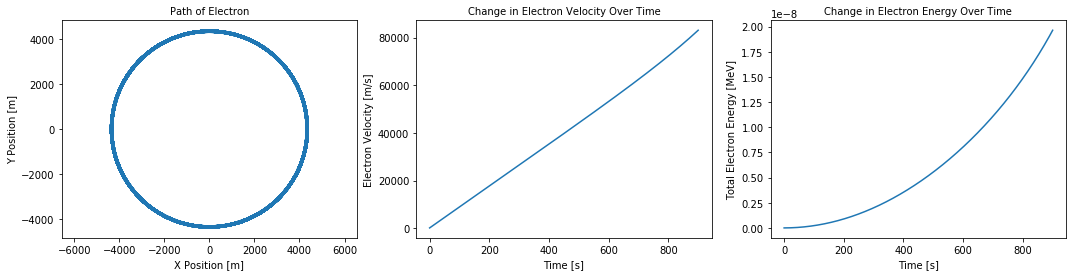

Electron Velocities:
[  100.39573451   100.79146901   101.18720352 ... 83095.0524829
 83095.57332717 83096.09417523]
Electron Energies:
[2.87065401e-14 2.89334693e-14 2.91603984e-14 ... 1.96290400e-08
 1.96292861e-08 1.96295322e-08]


In [50]:
#This part of the code sets up all the variables and arrays needed to make the simulation work:

#Importing libraries:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

#Creating a function that can simulate the electron within the synchrotron
def SimSynchro(radius,e_field_strength,time,its):
    
#Setting up constants:
    q = -1.60217662e-19 #in Coulombs
    m = 9.10938356e-31 #in kg
    R = radius #in meters
    c = 2.99792458e8 #in meters/s
    m0c2 = 0.5109990645047279 #electron rest mass energy (in MeV)

    B_scaling_const = m/(np.absolute(q*R)) #CANNOT be changed
    #print(B_scaling_const)
    E_scaling_const =e_field_strength #CAN be changed

    #Creating a variable that will be used to aid in the switching between classical and relativistic energy:
    #using_relativistic = 0 #0 = use classical energy, 1 = use relativistic energy

    #Setting up variables for the electron's movement:
    electron_pos = np.array([R,0,0]) #x position, y position, z position (in meters)
    electron_vel = np.array([0,100,0]) #x velocity, y velocity, z velocity (in m/s)
    #print(electron_pos[0])

    #Setting up variables for the electric field:
    E_field_mag = E_scaling_const #(in V/m)
    E_field = -1*E_field_mag*(electron_vel/np.linalg.norm(electron_vel)) #E field points in the direction opposite of the electron's velocity

    #Setting up variables for the magnetic field:
    B_field_mag = B_scaling_const*np.linalg.norm(electron_vel) #(in T) 
    B_field = np.array([0,0,B_field_mag]) #B field points in the -z direction
    #print(B_field)

    #Setting up constants for the simulation loop:
    duration = time #in seconds
    num_iterations = its
    timestep = duration/num_iterations
    #print(timestep)

    #Setting up the vectors for the Boris Algorithm:
    t = ((q*timestep)/(2*m))*B_field
    s = 2*t/(1+np.linalg.norm(t))
    v_minus = np.array([0,0,0])
    v_prime = v_minus + np.cross(v_minus,t)
    v_plus = v_minus + np.cross(v_prime,s)

    #Setting up arrays for the simulation loops:
    time_array = np.linspace(0,duration,num=num_iterations)
    electron_x_pos_array = np.array([])
    electron_y_pos_array = np.array([])
    electron_vel_array = np.array([])
    electron_energy_array = np.array([])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#This part of the code actually runs the simulation:

    for iteration in time_array:

        #Updating the electric field:
        E_field = -1*E_field_mag*(electron_vel/np.linalg.norm(electron_vel))
        #E_field = np.array([0,E_field_mag,0]) #E field is oriented along the y-axis
        #print(E_field)
    
        #Calculating the electric force acting on the electron:
        E_field_force = q*E_field
        #print(E_field_force)
  
        #We have to add the effects of the electric field force before calculating the magnetic field strength:
        electron_vel = electron_vel + ((E_field_force/m)*(timestep))
    
        #Updating the magnetic field:
        B_field_mag = B_scaling_const*np.linalg.norm(electron_vel) #(in T) 
        B_field = np.array([0,0,B_field_mag]) #B field points in the -z direction
        #print(B_field)
    
        #Calculating the magnetic force acting on the electron:
        B_field_force = np.cross(q*electron_vel,B_field)
        #print(B_field_force)
 
        #Boris Algorithm Equations for velocity due to magnetic field:
        v_minus = electron_vel + ((B_field_force/m)*(timestep/2))
    
        t = ((q*timestep)/(2*m))*B_field
        s = 2*t/(1+np.linalg.norm(t))
        v_prime = v_minus + np.cross(v_minus,t)
        v_plus = v_minus + np.cross(v_prime,s)
    
    
        #Updating the electron's velocity and position:
        vel_from_B = (v_plus + v_minus)/2
        #vel_from_B = v_plus + ((B_field_force/m)*(timestep/2))
        electron_vel = vel_from_B#+ ((E_field_force/m)*(timestep))
    
    
        #Updating the electron's position:
        electron_pos = electron_pos + (electron_vel*timestep)
        #print(electron_pos)
    
        #Updating the electron's energy:
        gamma = 1/np.sqrt(1-np.power((np.linalg.norm(electron_vel)/c),2))
        electron_energy = m0c2*(gamma-1)
    
        #Populating the arrays:
        electron_x_pos_array = np.append(electron_x_pos_array,electron_pos[0])
        electron_y_pos_array = np.append(electron_y_pos_array,electron_pos[1])
        electron_energy_array = np.append(electron_energy_array,electron_energy)
        electron_vel_array = np.append(electron_vel_array,np.linalg.norm(electron_vel))
       
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #This part of the code plots the data we gathered from the simulation:
    #Plotting the important data:    
    fig, axes= plt.subplots(nrows=1, ncols=3,figsize=(18,4))
    
    axes[0].plot(electron_x_pos_array,electron_y_pos_array)
    axes[0].axis('equal')
    axes[0].set_title('Path of Electron', fontsize=10)
    axes[0].set_xlabel('X Position [m]')
    axes[0].set_ylabel('Y Position [m]')

    axes[1].plot(time_array,electron_vel_array)
    axes[1].set_title('Change in Electron Velocity Over Time', fontsize=10)
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Electron Velocity [m/s]')

    axes[2].plot(time_array,electron_energy_array)
    axes[2].set_title('Change in Electron Energy Over Time', fontsize=10)
    axes[2].set_xlabel('Time [s]')
    axes[2].set_ylabel('Total Electron Energy [MeV]')

    plt.show()
    
    print('Electron Velocities:')
    print(electron_vel_array)
    print('Electron Energies:')
    print(electron_energy_array)
    
#Calling the function:
SimSynchro(4297,5e-10,900,200000)


## <ins>Results of Part 1:


As can be seen from the above figures, the electron stayed roughly within the bounds of the accelerator circle and increased in velocity for the duration of the test.  By the end of the acceleration, the velocity had increased by a factor of ~830, going from 100 m/s to ~83,000 m/s, and the kinetic energy of the electron increased by a factor of ~690,000, going from $2.86 \times 10^{-14}$ MeV to $1.96 \times 10^{-8}$ MeV. This closely matches, what we would expect from the constant acceleration of this electron, telling us that the simulation was successful in that regard.  But, there are immediate problems with this method of simulation.

### The Failings of This Simulation:

The code allows us to model the synchrotron accurately, but not in a real world timescale that will allow us to observe the electron hitting relativistic speeds.  Because the electron is moving in a circle and constantly changing the direction in which it is accelerating, we need a certain resolution of iterations in order to make sure that the radius of the particle's path stays close to the desired radius. The electron begins to spiral outside of the deisred path and the simulation begins to return bad data.  An example of this spiraling behavior caused by inadequete iteration resolution is shown in the code box below that runs the same simulation, but with only half of the resolution:

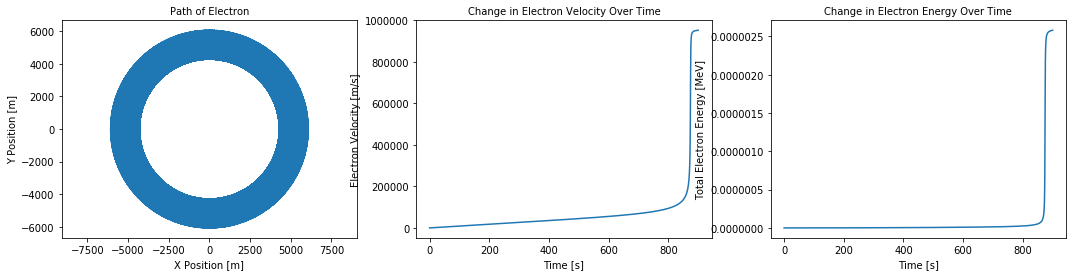

Electron Velocities:
[1.00791469e+02 1.01582938e+02 1.02374407e+02 ... 9.52828067e+05
 9.52829409e+05 9.52830750e+05]
Electron Energies:
[2.89334693e-14 2.93873276e-14 2.98411860e-14 ... 2.58095883e-06
 2.58096610e-06 2.58097337e-06]


In [3]:
SimSynchro(4297,5e-10,900,100000)

I've found that anything lower than ~220 iterations per second of simulation time at this test's max speed of ~83,000 m/s will cause these severe spiraling behavior.  Extrapolating this number out, we can see that the following will have to be true to scale up this simulation to relativistic speeds:


$$E = m_0c^2\gamma = 2m_0c^2$$

$$\gamma = 2 = \frac{1}{\sqrt{1 - \frac{v^2}{c^2}}}$$

This Lorentz factor of two corresponds to the following velocity:

$$v = (\frac{\sqrt{3}}{2})c = 2.598 \times 10^8 \space \frac{m}{s}$$

At this velocity, we would need to have this many iterations per second:

$$220 \frac{iterations}{second} * (\frac{2.598 \times 10^8}{83,000}) = 688,646 \frac{iterations}{second}$$

The above test took my computer ~70 seconds to complete 200,000 iterations.  At this rate, the simulation would take ~240 seconds (or 4 minutes) to complete just a single second of the simulation.  Our current electric field strength of $5 \times 10^{-10}$ V/m accelerates the electron at 87.935 m/s^2, meaning that it would take ~820 hours of simulation time to get the electrons moving at relativistic speeds ($\gamma = 2, v = 2.58 \times 10^{8}$ m/s), which corresponds to 22.49 years of real world calculation time.  In effect, what this means is that the simulation is not at all scalable for the energies that I was hoping to use it for.  So, we need to find another way of modelling the synchrotron.

##  <ins>Part 2:</ins> 1D Numerical Model without Energy Loss

Becuase the synchrotron that I'm trying to replicate is perfectly circular with a uniform magnetic field and is powered by an electric field that always provides the same acceleration, the change in velocity and energy of the electron does not vary with position and varies only with time.  This means that rather than worrying about how the electron's velocity will affect its position, we can evaluate only how the passage of time will affect its velocity and its energy.  This greatly simplifies the simulation without compromising on its accuracy, which will greatly reduce the computational power needed and will hopefully allow us to analyze the electron at relativistic speeds. 

### New Assumptions

The shift to a single dimensional model requires that some assumptions be made that weren't necessary in the first model.  

Firstly, because the magnetic field never does work on the electron, it will have no impact on magnitude of the electron's velocity.  Therefore, we do not need to consider the  magnitude of the electric field or its effects in the new model, we  can simply define its magnitude to be proportional to the velocity of the electron such that the electron's path traces out a circle of fixed radius and leave it at that.  So, for all intents and purposes the magnetic field will not appear in the new model.

Secondly, we will still assume that the electric field is of a fizxed magnitude and always points in the direction opposite of the electron's velocity.  As we saw in the first model, this type of electric field causes a constant acceleration that does not change.  This means that rather than calculating the acceleration due to the electric field in every iteration, we can calculate it once and then just apply it every iteration.  This too should hopefully reduce the computing workload.

Thirdly, because this model is going to be run on a longer timescale and will hopefully reach relativistic speeds, we will need to make an adjustment to the way that the acceleration and velocity are applied to the electron by factoring in relativistic length contraction and relativistic time dilation:

Relativistic Length Contraction:

$$L = \frac{L_0}{\gamma}$$


Relativistic Time Dilation: 

$$T = T_0 \gamma$$

Putting these together gives us that:  

$$v = \frac{distance}{time} = \frac{L_0/\gamma}{T_0 \gamma} = \frac{v_0}{\gamma^2}$$

$$a = \frac{distance}{time^2} = \frac{L_0/\gamma}{T_0^2 \gamma^2} = \frac{a_0}{\gamma^3}$$

Now that we have gone over all the changes between this model and the last, we can get into the code:

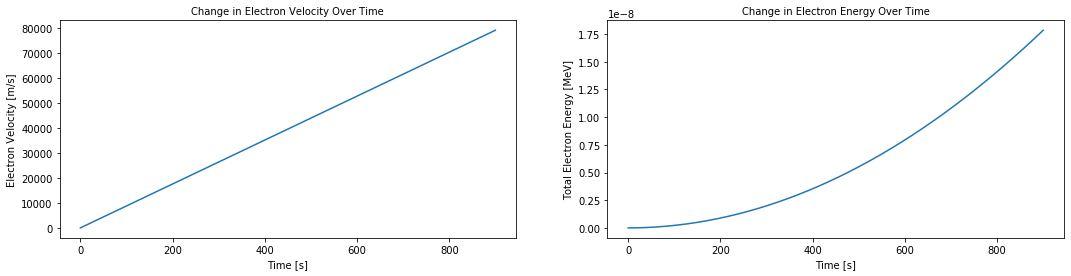

Electron Velocities:
[  107.9146901    115.8293802    123.74407031 ... 79231.06979796
 79238.98448751 79246.89917705]
Electron Energies:
[2.84796109e-14 3.31316589e-14 3.82375653e-14 ... 1.78423887e-08
 1.78459538e-08 1.78495195e-08]


In [4]:
def SimSynchro1D(radius,e_field_strength,time,its):
    
    #~~~~~~~~~~~~~~~ Preparation Step ~~~~~~~~~~~~~~~~~~
    
    #Setting up constants:
    q = -1.60217662e-19 #in Coulombs
    m = 9.10938356e-31 #in kg
    R = radius #in meters
    c = 2.99792458e8 #in meters/s
    m0c2 = 0.5109990645047279 #electron rest mass energy (in MeV)
    
    E_field_acceleration = (-e_field_strength*q)/m
    
    electron_vel = 100;
    
    gamma = 1/np.sqrt(1-np.power((electron_vel/c),2))
    
    electron_energy = m0c2*gamma
    
    #Setting up constants for the simulation loop:
    duration = time #in seconds
    num_iterations = its
    timestep = duration/num_iterations
    #print(timestep)
    
    time_array = np.linspace(0,duration,num=num_iterations)
    electron_vel_array = np.array([])
    electron_energy_array = np.array([])
    
    #~~~~~~~~~~~~~~~~~~~~ Simulation Step ~~~~~~~~~~~~~~~~~~~~~~
    
    for iteration in time_array:
        
        gamma = 1/np.sqrt(1-np.power((electron_vel/c),2))
        relatvistic_timestep = timestep*gamma
        relativistic_E_field_acceleration = E_field_acceleration/(np.power(gamma,3))
        
        electron_energy = m0c2*(gamma-1)
        
        electron_vel = electron_vel + (relativistic_E_field_acceleration*relatvistic_timestep)
        
        electron_energy_array = np.append(electron_energy_array,electron_energy)
        electron_vel_array = np.append(electron_vel_array,electron_vel)
        
    #~~~~~~~~~~~~~~~ Plotting Step ~~~~~~~~~~~~~~~~~~
    
    fig, axes= plt.subplots(nrows=1, ncols=2,figsize=(18,4))

    axes[0].plot(time_array,electron_vel_array)
    axes[0].set_title('Change in Electron Velocity Over Time', fontsize=10)
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Electron Velocity [m/s]')

    axes[1].plot(time_array,electron_energy_array)
    axes[1].set_title('Change in Electron Energy Over Time', fontsize=10)
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Total Electron Energy [MeV]')

    plt.show()
    
    print('Electron Velocities:')
    print(electron_vel_array)
    print('Electron Energies:')
    print(electron_energy_array)
    
SimSynchro1D(4297,5e-10,900,10000)        



## <ins>Results of Part 2:
    
 The results of this test are much more promising than those of part 1.  We see values for the final velocity and energy that are very similar to those from test in part 1, but with fewer iterations and in a fraction of the time.  With this in mind, we can now successfully scale up the parameters of our simulation without taking up literal years of computational time.  We'll try this out in the code block below:

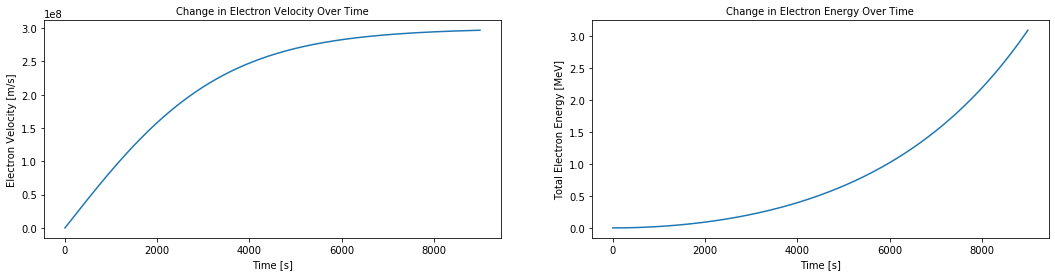

Electron Velocities:
[7.92469010e+04 1.58393797e+05 2.37540675e+05 ... 2.96754850e+08
 2.96756446e+08 2.96758041e+08]
Electron Energies:
[2.84796109e-14 1.78530862e-08 7.13222658e-08 ... 3.08681727e+00
 3.08775785e+00 3.08869869e+00]


In [10]:
SimSynchro1D(4297,5e-7,9000,10000)

Scaling up the parameters to the simulation yields similarly promising results that align with our expectations of the electron at these relativistic speeds.  In the above simulation, we increased the magnitude of the electric field by a factor 1000 to $5 \times 10^{-7}$ V/m and let the simulation run for 150 minutes instead of 15 minutes.  

The results are an electron travelling at $2.967 \times 10^{8}$ m/s (98.99% the speed of light) with an energy of 3.0887 MeV of kinetic energy.  It's not only the values themselves that seem to be consistent with reality, but the curves of thr velocity and acceleration graphs appear to show the correct trends of the velocity asymptotically approaching the speed of light and the energy approaching infinity.

At this point, I am confident in the new 1D model's ability to properly simulate the system and we are ready to move to the next step of implementing energy loss through synchrotron radiation into the model.

##  <ins>Part 3:</ins> 1D Numerical Model with Energy Loss

### Adding Magnetobremsstrahlung

This model will be very similar to the last except for that it will account for the energy lost by the electron due to magnetobremsstrahlung braking radiation.  The amount of radiation emitted by the electron at any time is proportional to the velocity of the electron and amount that the electron is being deflected by the magnetic field at that exact moment.  In other words, the amount of radiation being emitted at any point is proportional to the instantaneous velocity of the electron and the curvature of the accelerator at that point.  Because the accelerator we are simulating is circular, it has uniform curvature, which means that the only variable that comes into play when calculating the amount of energy lost to radiation is the velocity of the electron.  We see that if we look at the equation$^3$ for the power of synchrotron radiation generated by sources whose velocity and acceleration are perpendicular to each other (such as our case of the circular synchrotron):

$$P = \frac{q^2}{6 \pi \epsilon_0 m^4 c^5 r^2 sin^2(\alpha)}E^4 \beta^4$$

Although the equation might look big and scary, it is populated by values that we already know.  The only unfarmiliar symbols are $\alpha$, which is the angle between the magnetic field and the motion of the chaged particle (which is $\frac{\pi}{2}$ in this case), $E$, which is just the total energy of the particle ($m_0c^2 \gamma$), and $\beta$, which is just the ratio of the velocity of the particle to the speed of light ($\frac{v}{c}$).  Knowing all that, we can slightly simplify the power equation into the form we can program into the model:

$$P = \frac{q^2 E^4 \beta^4}{6 \pi \epsilon_0 m^4 c^5 r^2}$$

With the new energy loss term ready to add, we can now move onto coding the new model:

$^3$Equation taken from Wikipedia: https://en.wikipedia.org/wiki/Synchrotron_radiation

Time [s]:
217.08217082170822
Peak Electron Energy [MeV]:
148.98895303904058


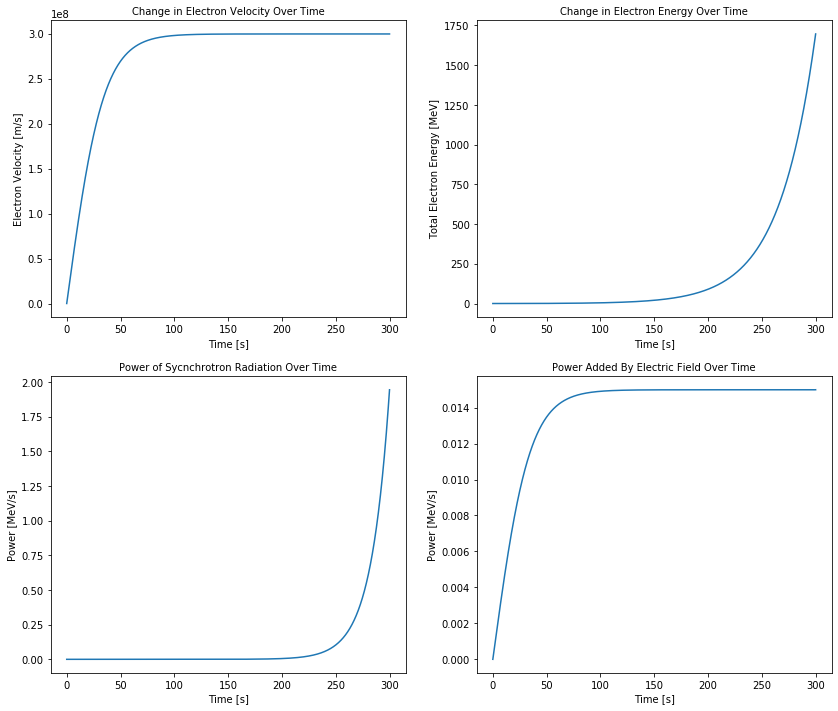

In [118]:
def SimSynchro1D_EL(radius,e_field_strength,time,its):
    
    #~~~~~~~~~~~~~~~ Preparation Step ~~~~~~~~~~~~~~~~~~
    
    #Setting up constants:
    q = -1.60217662e-19 #in Coulombs
    m = 9.10938356e-31 #in kg
    R = radius #in meters
    c = 2.99792458e8 #in meters/s
    m0c2 = 0.5109990645047279 #electron rest mass energy (in MeV
    
    E_field_acceleration = (-e_field_strength*q)/m
    
    electron_vel = 100;
    
    gamma = 1/np.sqrt(1-np.power((electron_vel/c),2))
    
    electron_energy = m0c2*gamma
    
    #Boolean that will help in knowing the first time there is a net energy loss
    first_net_loss = 0
    
    #Setting up constants for the simulation loop:
    duration = time #in seconds
    num_iterations = its
    timestep = duration/num_iterations
    #print(timestep)
    
    time_array = np.linspace(0,duration,num=num_iterations)
    electron_vel_array = np.array([])
    electron_energy_array = np.array([])
    power_lost_array = np.array([])
    power_gained_array = np.array([])
    
    #~~~~~~~~~~~~~~~~~~~~ Simulation Step ~~~~~~~~~~~~~~~~~~~~~~
    
    for iteration in time_array:
        
        gamma = 1/np.sqrt(1-np.power((electron_vel/c),2))
        relativistic_timestep = timestep*gamma
        relativistic_E_field_acceleration = E_field_acceleration/(np.power(gamma,3))
        
        electron_energy = m0c2*(gamma-1)
        
        EL_const_term = (np.power(q,2)*624150647990.3)/(6*np.pi*np.power(m*gamma,2)*np.power(c,5)*np.power(R,2)*8.854187e-12);
        electron_total_energy = m0c2*(gamma)
        beta = electron_vel/c;
        
        #This is the energy (in MeV) lost to radiation duting that timestep
        Power_Lost = EL_const_term*np.power(electron_total_energy,4)*np.power(beta,4)
        Energy_Lost = Power_Lost*timestep
        
        new_electron_vel = electron_vel + (relativistic_E_field_acceleration*relativistic_timestep)
        new_gamma = 1/np.sqrt(1-np.power((new_electron_vel/c),2))
        
        #This is total energy of the electron after it has lost some energy to radiation:
        new_electron_total_energy = m0c2*(new_gamma)
        
        Power_Gained = (new_electron_total_energy - electron_total_energy)/relativistic_timestep
        
        #Now we can derive the electron velocity from new energy value
        #electron_vel = c*np.sqrt(1-np.power(m0c2/new_electron_total_energy,2))
        electron_vel = electron_vel + (relativistic_E_field_acceleration*relativistic_timestep)
        
        #Finding the new kinetic energy of the electron:
        #electron_energy = new_electron_total_energy - m0c2
        
        electron_energy_array = np.append(electron_energy_array,electron_energy)
        electron_vel_array = np.append(electron_vel_array,electron_vel)
        power_lost_array = np.append(power_lost_array,Power_Lost)
        power_gained_array = np.append(power_gained_array,Power_Gained)
        
        if Power_Gained <= Power_Lost and first_net_loss == 0:
            #Printing the time of the net loss:
            print("Time [s]:")
            print(iteration);
            #Printing the electron energy at this moment:
            print("Peak Electron Energy [MeV]:")
            print(new_electron_total_energy)
            first_net_loss = 1
        
    #~~~~~~~~~~~~~~~ Plotting Step ~~~~~~~~~~~~~~~~~~
    
    fig, axes= plt.subplots(nrows=2, ncols=2,figsize=(14,12))

    axes[0,0].plot(time_array,electron_vel_array)
    axes[0,0].set_title('Change in Electron Velocity Over Time', fontsize=10)
    axes[0,0].set_xlabel('Time [s]')
    axes[0,0].set_ylabel('Electron Velocity [m/s]')

    axes[0,1].plot(time_array,electron_energy_array)
    axes[0,1].set_title('Change in Electron Energy Over Time', fontsize=10)
    axes[0,1].set_xlabel('Time [s]')
    axes[0,1].set_ylabel('Total Electron Energy [MeV]')
    
    axes[1,0].plot(time_array,power_lost_array)
    axes[1,0].set_title('Power of Sycnchrotron Radiation Over Time', fontsize=10)
    axes[1,0].set_xlabel('Time [s]')
    axes[1,0].set_ylabel('Power [MeV/s]')
    
    axes[1,1].plot(time_array,power_gained_array)
    axes[1,1].set_title('Power Added By Electric Field Over Time', fontsize=10)
    axes[1,1].set_xlabel('Time [s]')
    axes[1,1].set_ylabel('Power [MeV/s]')


    plt.show()
    
    #print('Electron Velocities:')
    #print(electron_vel_array)
    #print('Electron Energies:')
    #print(electron_energy_array)
    
SimSynchro1D_EL(4297,5e-5,300,100000)

## <ins> Final Results

Based on my final model of the LHC, my calculated peak electron energy is ~149 MeV, which is 0.149 GeV.  To be completely honest, I do not know how this number compares with the LHC's actual ability to accelerate electrons.  The only data I could find was on the LHC's peak proton beam energy, which was 6.5 TeV$^4$ or 6500 GeV.  This may seem like my estimation is way off, but we have to remember how much more massive protons are than electrons, which if we remember back to the synchrotron radiation power formula, means that the protons will lose much less energy in the form of radiation than the electrons do.  So, although this energy is quite small relative to the peak possible proton beam energy, I'm confident in my modelling methodology and believe that my predicted peak electron energy of 148.99 MeV is close to the truth.


$^4$Number taken from CERN website: https://home.cern/science/engineering/restarting-lhc-why-13-tev